In [1]:
from agent import QEDRewardMolecule, Agent
import numpy as np
import random
import torch
import argparse

class Args(argparse.Namespace):
    start_molecule = None
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 2000
    optimizer = "Adam"
    polyak = 0.995
    atom_types = ["C", "O", "N"]
    max_steps_per_episode = 30
    allow_removal = True
    allow_no_modification = True
    allow_bonds_between_rings = False
    allowed_ring_sizes = [3, 4, 5, 6]
    replay_buffer_size = 10_000
    learning_rate = 1e-4
    gamma = 0.95
    fingerprint_radius = 3
    fingerprint_length = 1024
    discount_factor = 0.9
    seed=9
    model_path = "dqn_weights.pth"

config = Args()
np.random.seed(config.seed)
random.seed(config.seed)
torch.manual_seed(config.seed)
torch.cuda.manual_seed(config.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

environment = QEDRewardMolecule(
            discount_factor=config.discount_factor,
            atom_types=set(config.atom_types),
            init_mol=config.start_molecule,
            allow_removal=config.allow_removal,
            allow_no_modification=config.allow_no_modification,
            allow_bonds_between_rings=config.allow_bonds_between_rings,
            allowed_ring_sizes=set(config.allowed_ring_sizes),
            max_steps=config.max_steps_per_episode,
            record_path=True
        )

agent = Agent(
            config.fingerprint_length + 1,
            1,
            device,
            config,
            pretrained=True
        )

In [10]:
import utils

In [4]:
environment.initialize()
done = False
while not done:
    steps_left = config.max_steps_per_episode - environment.num_steps_taken
    valid_actions = list(environment.get_valid_actions())
    observations = np.vstack(
            [
                np.append(
                    utils.get_fingerprint(act, config.fingerprint_length, config.fingerprint_radius),
                    steps_left,
                )
                for act in valid_actions
            ]
        )
    observations_tensor = torch.Tensor(observations)

    act_index = agent.get_action(observations_tensor, 1.0)
    action = valid_actions[act_index]

    result = environment.step(action)
    next_state, reward, done = result

In [35]:
from rdkit import Chem
from rdkit.Chem import QED

frames = []
for i, mol in enumerate(environment.get_path()):
    if i == 0:
        continue
    
    reward = QED.qed(Chem.MolFromSmiles(mol))
    img = environment.visualize_state(mol, legend=f"Step: {i}\nQED: {round(reward, 3)}")
    frames.append(img)

In [34]:
def make_gif(frames):
    frame_one = frames[0]
    frame_one.save("download.gif", format="GIF", append_images=frames,
               save_all=True, duration=1000, loop=1)

make_gif(frames)

In [8]:
environment.get_path()

[None,
 'O',
 'OO',
 'O',
 'O',
 'O=O',
 'OO',
 'O',
 'O',
 'OO',
 'O',
 'O',
 'O=O',
 'OO',
 'COO',
 'CO',
 'N#CO',
 'COC#N',
 'N#COCN',
 'N#COCN',
 'N#COC(=N)N',
 'N=C(N)OCN',
 'N=C(N)OC(N)N',
 'CNC(N)OC(=N)N',
 'C=NC(N)OC(=N)N',
 'C=NC(N)OC=N',
 'NC1N=CN=CO1',
 'N=CN=COCN',
 'CC(=N)N=COCN',
 'C=NCOC=NC(C)=N',
 'C=NCOCNC(C)=N']

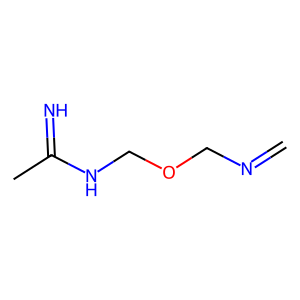

In [7]:
environment.visualize_state()

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

loss_df = pd.read_csv("dqn_run_loss.csv")
loss_df = loss_df[["Step", "run_1k_episodes_mstep30 - episode_loss"]]
loss_df.columns = ["Step", "Loss"]

loss_df["Episode"] = np.arange(len(loss_df))
#run_info_df = pd.read_csv("dqn_run2.csv")
#run_info_df = run_info_df[98:]

In [46]:
loss_df

,Step,Loss,Episode
0,159,0.009223,0
1,193,0.005164,1
2,227,0.008501,2
3,261,0.005891,3
4,295,0.004767,4
...,...,...,...
991,33853,0.001448,991
992,33887,0.001788,992
993,33921,0.002173,993
994,33955,0.001400,994


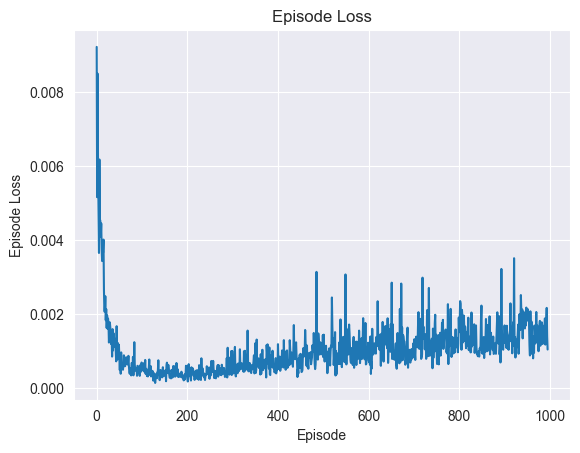

In [48]:
sns.lineplot(data=loss_df, x="Episode", y="Loss")
plt.title("Episode Loss")
plt.ylabel("Episode Loss")
plt.xlabel("Episode")
plt.savefig("loss.png")
# plt.show()

In [59]:
reward_df = pd.read_csv("dqn_run_valreward.csv")
reward_df

,Step,run_1k_episodes_mstep30 - val-reward,run_1k_episodes_mstep30 - val-reward__MIN,run_1k_episodes_mstep30 - val-reward__MAX
0,30,0.416793,0.416793,0.416793
1,62,0.156372,0.156372,0.156372
2,94,0.211495,0.211495,0.211495
3,126,0.353846,0.353846,0.353846
4,160,0.233021,0.233021,0.233021
...,...,...,...,...
995,33854,0.546518,0.546518,0.546518
996,33888,0.275927,0.275927,0.275927
997,33922,0.616222,0.616222,0.616222
998,33956,0.402319,0.402319,0.402319


In [60]:
reward_df = pd.read_csv("dqn_run_valreward.csv")
reward_df = reward_df[["Step", "run_1k_episodes_mstep30 - val-reward"]]
reward_df.columns = ["Step", "Reward"]
reward_df["Episode"] = np.arange(len(reward_df))
reward_df

,Step,Reward,Episode
0,30,0.416793,0
1,62,0.156372,1
2,94,0.211495,2
3,126,0.353846,3
4,160,0.233021,4
...,...,...,...
995,33854,0.546518,995
996,33888,0.275927,996
997,33922,0.616222,997
998,33956,0.402319,998


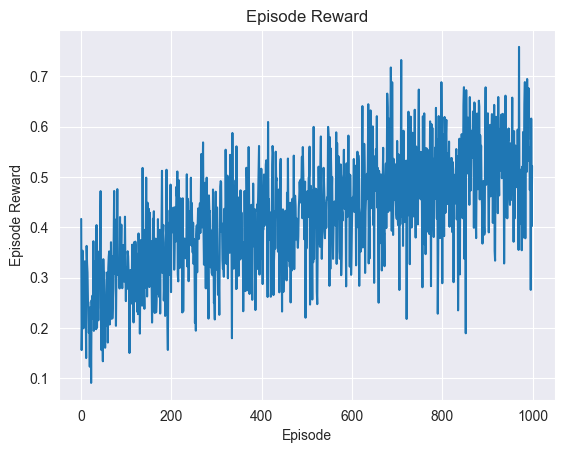

In [64]:
sns.lineplot(data=reward_df, x="Episode", y="Reward", estimator="mean")
plt.title("Episode Reward")
plt.ylabel("Episode Reward")
plt.xlabel("Episode")
plt.savefig("reward.png")
# plt.show()

In [66]:
smiles_df = pd.read_csv('result_smiles.csv', sep=';')
smiles_df

,Reward,Smiles
0,0.811741,C=C1C(=C)N1Cc1o[nH]c1-c1c[nH]on(C)cn1
1,0.745750,COC1(C)C2(N=C3C=CN32)C(=O)C1(N=O)n1[nH]o1
2,0.706268,CC1=C(O)NC1C12OCOC1(C)n1onc12
3,0.748589,C=CN=C1C(=N)C(CN=C)N1C1=NOC2=C(C2)O1
4,0.711395,CC(O)=CCOc1[nH]oc1OC1CC1
5,0.815499,C=Cc1c[nH]c(C2C3=CC(=C3N)C(C)C2C)n1
6,0.753985,C=C1N=NN(C2CC=N2)N2C(O)C(CC)C12
7,0.762799,CC1N=C(OC(C)c2c#c[nH]c2)N(O)O1
8,0.844276,CCC(CC)C1(O)CC2=NC(O1)C1=NC(C)=CON21
9,0.833951,C=C(C)C1=CC2=COCNC3(OC)N=NC(O2)(O3)C1=C


In [67]:
molecules = [Chem.MolFromSmiles(smile) for smile in smiles_df["Smiles"].values]
molecules

In [68]:
from rdkit.Chem import Descriptors
logps = [Descriptors.MolLogP(curr_mol) for curr_mol in molecules]
Chem.Draw.MolsToGridImage(molecules[:10], molsPerRow=5, subImgSize=(400,400),
                             legends=[f'LogP: {round(logp, 2)}\nQED: {round(qed, 2)}' for logp, qed in zip(logps, smiles_df["Reward"])], 
                             returnPNG=False).save("smiles_grid.png")